# Hyperparameter Optimization Example

This Jupyter Notebook is made for illustrating - through a mixture of slides and code in an interactive fashion - the different methods for optimising Hyperparameters for Machine Learning models. First it shows the most naive, manual approach, then grid search, and finally bayesian optimization. 


### Authors and Date:
- Christian Michelsen & Troels Petersen (Niels Bohr Institute)   
- 2022-05-01 (latest update)

***

This notebook uses the __[HTRU2 Pulsar dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2)__ dataset as example data for Hyperparameter Optimization (HPO).

The focus on this small example is neither the actual code nor getting any specific results, but - hopefully - getting a better understanding of HPO. This is also why we don't describe the code in great detail - and simply load the dataset from a csv file directly - but the first part of the code should hopefully look familiar.

1. Naive, manual approach
2. Grid search
3. Random search
4. Bayesian optimization
5. "Full" scan over parameter space
6. New methods
7. New software


- __[HTRU2 Pulsar dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2)__

- Focus on the understanding of HPO, not the actual code nor the data!

***

### Nomenclature (i.e. naming scheme)
- Machine Learning Model: $\mathcal{A}$
- $N$ hyperparameters
- Domain: $\Lambda_n$
- Hyperparameter configuration space: $\mathbf{\Lambda}=\Lambda_1 \times \Lambda_2 \times \dots \times \Lambda_N $
- Vector of hyperparameters: $\mathbf{\lambda} \in \mathbf{\Lambda}$
- Specific ML model: $\mathcal{A}_\mathbf{\lambda}$

### Domain of hyperparameters:

1. real
2. integer
3. binary
4. categorical

### Goal:

Given a dataset $\mathcal{D}$, find the vector of HyperParameters $\mathbf{\lambda}^{*}$, which performes "best", i.e. minimises the expected loss function $\mathcal{L}$ for the model $\mathcal{A}_\mathbf{\lambda}$ on the test set of the data $D_\mathrm{test}$:

$$ \mathbf{\lambda}^{*} = \mathop{\mathrm{argmin}}_{\mathbf{\lambda} \in \mathbf{\Lambda}} \mathbb{E}_{D_\mathrm{test} \thicksim \mathcal{D}} \, \left[ \mathbf{V}\left(\mathcal{L}, \mathcal{A}_\mathbf{\lambda}, D_\mathrm{test}\right) \right]  $$

In practice we have to approximate the expectation above. 

***

First, we import the modules we want to use:

In [194]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_iris, load_wine
from sklearn.metrics import accuracy_score
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, poisson, expon


We read in the data:

In [195]:
df = pd.read_csv('./data/Pulsar_data.csv')

df.head(100)

,Mean_SNR,STD_SNR,Kurtosis_SNR,Skewness_SNR,Class
0,27.555184,61.719016,2.208808,3.662680,1
1,1.358696,13.079034,13.312141,212.597029,1
2,73.112876,62.070220,1.268206,1.082920,1
3,146.568562,82.394624,-0.274902,-1.121848,1
4,6.071070,29.760400,5.318767,28.698048,1
...,...,...,...,...,...
95,33.867893,71.790032,1.998109,2.462844,1
96,15.820234,52.439584,3.382535,10.303138,1
97,56.295987,85.124408,1.229159,-0.059996,1
98,4.854515,26.990192,6.453153,44.427162,1


We then divide the dataset in input features (X) and target (y):

In [196]:
X = df.drop(columns='Class')
y = df['Class']
feature_names = df.columns.tolist()[:-1]

print(feature_names)

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)
X_train.head(10)

['Mean_SNR', 'STD_SNR', 'Kurtosis_SNR', 'Skewness_SNR']
(3278, 4)


,Mean_SNR,STD_SNR,Kurtosis_SNR,Skewness_SNR
233,159.849498,76.740010,-0.575016,-0.941293
831,4.243311,26.746490,7.110978,52.701218
2658,1.015050,10.449662,15.593479,316.011541
2495,2.235786,19.071848,9.659137,99.294390
2603,2.266722,15.512103,9.062942,99.652157
111,121.404682,47.965569,0.663053,1.203139
1370,35.209866,60.573157,1.635995,1.609377
1124,199.577759,58.656643,-1.862320,2.391870
2170,0.663043,8.571517,23.415092,655.614875
2177,3.112876,16.855717,8.301954,90.378150


And check out the y values (which turns out to be balanced):

In [197]:
y_train.head(10)

233     1
831     1
2658    0
2495    0
2603    0
111     1
1370    1
1124    1
2170    0
2177    0
Name: Class, dtype: int64

In [198]:
y_train.value_counts()

0    1319
1    1303
Name: Class, dtype: int64

***

## Part A: Naïve Approach

- Manual configuration
- _"[Babysitting is also known as Trial & Error or Grad Student Descent in the academic field](https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/)"_

In [199]:
def fit_and_grapth_estimator(estimator):
    
    estimator.fit(X_train, y_train)
    
    accuracy = accuracy_score(y_train, estimator.predict(X_train))
    print(f'Training Accuracy: {accuracy:.4f}')
    
    class_names = [str(i) for i in range(y_train.nunique())]
    graph = Source(tree.export_graphviz(estimator, 
                                        out_file=None, 
                                        feature_names=feature_names, 
                                        class_names=class_names, 
                                        filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


def plot_tree(max_depth=1, min_samples_leaf=1):
    
    estimator = DecisionTreeClassifier(random_state=42, 
                                       max_depth=max_depth, 
                                       min_samples_leaf=min_samples_leaf)
    
    return fit_and_grapth_estimator(estimator)

display(interactive(plot_tree, 
                    max_depth=(1, 10, 1), 
                    min_samples_leaf=(1, 100, 1)))

interactive(children=(IntSlider(value=1, description='max_depth', max=10, min=1), IntSlider(value=1, descripti…

__(Test this interactively in notebook)__

And test this configuration out on the test data:

In [200]:
clf_manual = DecisionTreeClassifier(random_state=42, 
                                    max_depth=10, 
                                    min_samples_leaf=1)

clf_manual.fit(X_train, y_train)
accuracy_manual = accuracy_score(y_test, clf_manual.predict(X_test))
print(f'Accuracy Manual: {accuracy_manual:.4f}')

Accuracy Manual: 0.8277


***

## Part B: Grid Search

Grid Search: 

- _full factorial design_ 
- Cartesian product
- Curse of dimensionality (grows exponentially)


![title](./images/GridSearch.png)

***

__[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
)__ with Scikit Learn:

In [201]:
parameters_GridSearch = {'max_depth':[1, 10, 100], 
                         'min_samples_leaf':[1, 10, 100],
                        }

In [202]:
clf_DecisionTree = DecisionTreeClassifier(random_state=42)

In [203]:
GridSearch = GridSearchCV(clf_DecisionTree, 
                          parameters_GridSearch, 
                          cv=5, 
                          return_train_score=True, 
                          refit=True, 
                         )

In [204]:
GridSearch.fit(X_train, y_train);

In [205]:
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)        

In [206]:
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.4f}\n")

Grid Search: 	Best parameters:  {'max_depth': 1, 'min_samples_leaf': 1} , Best scores: 0.8551



In [207]:
GridSearch_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009284,0.001660,0.003762,0.000683,1,1,"{'max_depth': 1, 'min_samples_leaf': 1}",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
1,0.004586,0.001383,0.002067,0.000625,1,10,"{'max_depth': 1, 'min_samples_leaf': 10}",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
2,0.004408,0.002333,0.002699,0.000554,1,100,"{'max_depth': 1, 'min_samples_leaf': 100}",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
3,0.015925,0.002782,0.002639,0.000873,10,1,"{'max_depth': 10, 'min_samples_leaf': 1}",0.847619,0.822857,0.858779,...,0.841729,0.011991,8,0.956128,0.948021,0.954242,0.962345,0.957102,0.955568,0.004633
4,0.012299,0.003771,0.002056,0.000648,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.845714,0.847619,0.853053,...,0.846300,0.008757,6,0.896042,0.898903,0.898475,0.893232,0.895615,0.896453,0.002066
5,0.006232,0.000720,0.001233,0.000391,10,100,"{'max_depth': 10, 'min_samples_leaf': 100}",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
6,0.009935,0.000639,0.001788,0.000694,100,1,"{'max_depth': 100, 'min_samples_leaf': 1}",0.826667,0.796190,0.841603,...,0.824190,0.015056,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.008770,0.000659,0.001416,0.000824,100,10,"{'max_depth': 100, 'min_samples_leaf': 10}",0.845714,0.849524,0.854962,...,0.845154,0.009863,7,0.896996,0.899857,0.898475,0.894185,0.896568,0.897216,0.001909
8,0.005853,0.000774,0.001490,0.000626,100,100,"{'max_depth': 100, 'min_samples_leaf': 100}",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340


In [208]:
clf_GridSearch = GridSearch.best_estimator_

In [209]:
accuracy_GridSearch = accuracy_score(y_test, clf_GridSearch.predict(X_test))
print(f'Accuracy Manual:      {accuracy_manual:.4f}')
print(f'Accuracy Grid Search: {accuracy_GridSearch:.4f}')

Accuracy Manual:      0.8277
Accuracy Grid Search: 0.8430


***

## Part C: Random Search

- $B$ function evaluations, $N$ hyperparameters, $y$ number of different values:

$$ y_{\mathrm{Grid Search}} = B^{1/N}, \quad y_{\mathrm{Random Search}} = B  $$

<img src="./images/RandomSearch.png" alt="Random Search" width="400"/>

- _"This failure of grid search is the rule rather than the exception in high dimensional
hyper-parameter optimization"_ [Bergstra, 2012]

- useful baseline because (almost) no assumptions about the ML algorithm being optimized.

***

__[Random Search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)__ with __[Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)__ using __[Scipy Stats](https://docs.scipy.org/doc/scipy/reference/stats.html)__ as PDFs for the parameters:

In [210]:
# specify parameters and distributions to sample from
parameters_RandomSearch = {'max_depth': expon(10), 
                           'min_samples_leaf': randint(1, 100)}

In [211]:
# run randomized search
n_iter_search = 9
RandomSearch = RandomizedSearchCV(clf_DecisionTree, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5, 
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [212]:
# fit the random search instance
RandomSearch.fit(X_train, y_train);

In [213]:
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

Random Search: 	Best parameters:  {'max_depth': 10.46926808997686, 'min_samples_leaf': 93} , Best scores: 0.855


In [214]:
RandomSearch_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.016740,0.000874,0.004500,0.001107,10.469268,93,"{'max_depth': 10.46926808997686, 'min_samples_...",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
1,0.008419,0.001227,0.002224,0.000383,10.202649,72,"{'max_depth': 10.20264850431815, 'min_samples_...",0.849524,0.862857,0.862595,...,0.854308,0.010440,6,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
2,0.006484,0.000594,0.001793,0.000740,10.912943,83,"{'max_depth': 10.912942553775952, 'min_samples...",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
3,0.006934,0.000531,0.001202,0.000416,10.105333,75,"{'max_depth': 10.105332644732893, 'min_samples...",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.860343,0.859840,0.001340
4,0.008580,0.000626,0.001739,0.000685,12.011231,24,"{'max_depth': 12.01123086447994, 'min_samples_...",0.847619,0.860952,0.868321,...,0.854310,0.012162,5,0.875536,0.879351,0.878456,0.875596,0.881792,0.878146,0.002373
5,0.010838,0.002493,0.002676,0.001072,11.052364,53,"{'max_depth': 11.052363846077553, 'min_samples...",0.849524,0.836190,0.862595,...,0.850883,0.012010,7,0.865045,0.862184,0.858913,0.861296,0.860343,0.861556,0.002054
6,0.008038,0.000836,0.001749,0.000653,13.503557,30,"{'max_depth': 13.503557475158312, 'min_samples...",0.843810,0.857143,0.853053,...,0.850877,0.006963,8,0.871245,0.873629,0.870353,0.869876,0.876072,0.872235,0.002313
7,0.006366,0.000514,0.001411,0.000504,10.238688,64,"{'max_depth': 10.238687625248946, 'min_samples...",0.849524,0.862857,0.862595,...,0.855072,0.009121,1,0.862184,0.858369,0.858913,0.859390,0.861296,0.860031,0.001460
8,0.011396,0.003467,0.002340,0.000691,14.855115,33,"{'max_depth': 14.85511460488853, 'min_samples_...",0.843810,0.838095,0.858779,...,0.844778,0.013052,9,0.870291,0.866953,0.867016,0.867493,0.868446,0.868040,0.001246


In [215]:
clf_RandomSearch = RandomSearch.best_estimator_

accuracy_RandomSearch = accuracy_score(y_test, clf_RandomSearch.predict(X_test))
print(f'Accuracy Manual:        {accuracy_manual:.4f}')
print(f'Accuracy Grid search:   {accuracy_GridSearch:.4f}')
print(f'Accuracy Random Search: {accuracy_RandomSearch:.4f}')

Accuracy Manual:        0.8277
Accuracy Grid search:   0.8430
Accuracy Random Search: 0.8430


***

## Part D: Bayesian Optimization

- Expensive black box functions $\Rightarrow$ need of smart guesses

1. Probabilistic Surrogate Model (to be fitted)  
   - Often Gaussian Processes 
2. Acquisition function  
   - Exploitation / Exploration  
   - Cheap to Computer
  
_[Brochu, Cora, de Freitas, 2010]_

<img src="./images/BO1.png" alt="Bayesian Optimization 1" width="600"/>

<img src="./images/BO2.png" alt="Bayesian Optimization 2" width="600"/>

<img src="./images/comparison_rs_bo.png" alt="BO vs. RS" width="600"/>


__[Bayesian Optimization](https://arxiv.org/pdf/1012.2599v1.pdf)__ with the Python package __[BayesianOptimization](https://github.com/fmfn/BayesianOptimization)__:


In [216]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def DecisionTree_CrossValidation(max_depth, min_samples_leaf, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = DecisionTreeClassifier(random_state=42, 
                                       max_depth=max_depth, 
                                       min_samples_leaf=min_samples_leaf)
    
    cval = cross_val_score(estimator, data, targets, scoring='accuracy', cv=5)
    
    return cval.mean()

In [217]:
def optimize_DecisionTree(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(max_depth, min_samples_leaf):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return DecisionTree_CrossValidation(max_depth=int(max_depth), 
                                            min_samples_leaf=int(min_samples_leaf), 
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [218]:
parameters_BayesianOptimization = {"max_depth": (1, 100), 
                                   "min_samples_leaf": (1, 100),
                                  }

BayesianOptimization = optimize_DecisionTree(X_train, 
                                             y_train, 
                                             parameters_BayesianOptimization, 
                                             n_iter=5)
print(BayesianOptimization.max)

|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
|  1        |  0.8551   |  38.08    |  95.12    |
|  2        |  0.849    |  73.47    |  60.27    |
|  3        |  0.8524   |  16.45    |  16.44    |
|  4        |  0.8551   |  6.75     |  86.75    |
|  5        |  0.8551   |  22.46    |  67.29    |
|  6        |  0.8551   |  21.86    |  65.88    |
|  7        |  0.8242   |  100.0    |  1.0      |
|  8        |  0.8551   |  100.0    |  100.0    |
|  9        |  0.8551   |  1.0      |  37.5     |
{'target': 0.8550716103235187, 'params': {'max_depth': 38.07947176588889, 'min_samples_leaf': 95.1207163345817}}


In [219]:
params = BayesianOptimization.max['params']

In [220]:
for key, val in params.items():
    params[key] = int(val)

In [221]:
clf_BO = DecisionTreeClassifier(random_state=42, **params)
clf_BO = clf_BO.fit(X_train, y_train)

In [222]:
accuracy_BayesianOptimization = accuracy_score(y_test, clf_BO.predict(X_test))
print(f'Accuracy Manual:                {accuracy_manual:.4f}')
print(f'Accuracy Grid Search:           {accuracy_GridSearch:.4f}')
print(f'Accuracy Random Search:         {accuracy_RandomSearch:.4f}')
print(f'Accuracy Bayesian Optimization: {accuracy_BayesianOptimization:.4f}')

Accuracy Manual:                0.8277
Accuracy Grid Search:           0.8430
Accuracy Random Search:         0.8430
Accuracy Bayesian Optimization: 0.8430


***

## Part D: Full Scan over Parameter Space

Only possible in low-dimensional space, slow

In [223]:
max_depth_array = np.arange(1, 30)
min_samples_leaf_array = np.arange(2, 31)
Z = np.zeros((len(max_depth_array), len(min_samples_leaf_array)))

for i, max_depth in enumerate(max_depth_array):
    for j, min_samples_leaf in enumerate(min_samples_leaf_array):
        
        clf = DecisionTreeClassifier(random_state=42, 
                                     max_depth=max_depth, 
                                     min_samples_leaf=
                                     min_samples_leaf)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        Z[i, j] = acc
        
# Notice: have to transpose Z to match up with imshow
Z = Z.T

Plot the results:

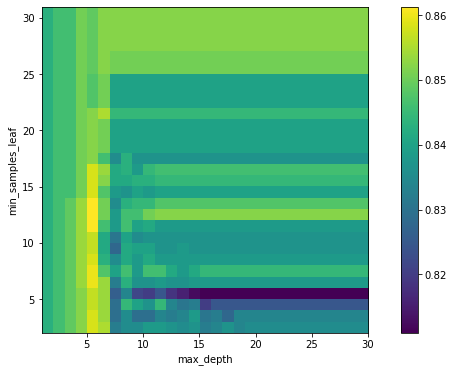

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))

# notice that we are setting the extent and origin keywords
CS = ax.imshow(Z, extent=[1, 30, 2, 31], cmap='viridis', origin='lower')
ax.set(xlabel='max_depth', ylabel='min_samples_leaf')

fig.colorbar(CS);

***

### Sum up:

<img src="./images/Chart.png" alt="Chart" width="800"/>

__[Guide To Hyperparameters Search For Deep Learning Models](https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/)__

## Part E: New Methods

Bayesian Optimization meets HyperBand (BOHB)

HyperBand:


<img src="./images/sh.gif" alt="BO vs. RS" width="600"/>

<img src="./images/comparison_rs_bo.png" alt="BO vs. RS" width="600"/>

<img src="./images/comparison-1.png" alt="BOHB" width="600"/>

__[BOHB: Robust and Efficient Hyperparameter Optimization at Scale](https://www.automl.org/blog_bohb/)__

## Part F: New Software

Optuna (see code)

In [225]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback
from optuna.pruners import MedianPruner
import lightgbm as lgb

#%%

# lgb_data_train = ...           # Here you have to come with a model yourself!
lgb_data_train = lgb.Dataset(X_train, label=y_train)

ModuleNotFoundError: No module named 'optuna'

In [ ]:
def objective(trial):

    boosting_types = ["gbdt", "rf", "dart"]
    boosting_type = trial.suggest_categorical("boosting_type", boosting_types)

    params = {
        "objective": "binary",
        "metric": 'auc',
        "boosting": boosting_type,
        "max_depth": 5,
        "max_depth": trial.suggest_int("max_depth", 2, 63),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-5, 10),
        "scale_pos_weight": trial.suggest_uniform("scale_pos_weight", 10.0, 30.0),
        "bagging_freq": 1, "bagging_fraction": 0.6,
        "verbosity": -1
    }

    N_iterations_max = 10_000
    early_stopping_rounds = 50

    if boosting_type == "dart":
        N_iterations_max = 100
        early_stopping_rounds = None

    cv_res = lgb.cv(
        params,
        lgb_data_train,
        num_boost_round=N_iterations_max,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False,
        seed=42,
        callbacks=[LightGBMPruningCallback(trial, "auc")],
    )

    num_boost_round = len(cv_res["auc-mean"])
    trial.set_user_attr("num_boost_round", num_boost_round)

    return cv_res["auc-mean"][-1]

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=50),
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-05-08 15:46:00,530] A new study created in memory with name: no-name-5109b564-59be-4590-9951-bd62f8c2dfc9
/opt/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2022-05-08 15:46:00,883] Trial 0 finished with value: 0.9257274934861961 and parameters: {'boosting_type': 'rf', 'max_depth': 39, 'min_child_weight': 8.632008168602535e-05, 'scale_pos_weight': 13.119890406724053}. Best is trial 0 with value: 0.9257274934861961.
[I 2022-05-08 15:46:01,174] Trial 1 finished with value: 0.925645717219157 and parameters: {'boosting_type': 'rf', 'max_depth': 45, 'min_child_weight': 1.3289448722869181e-05, 'scale_pos_weight': 29.398197043239886}. Best is trial 0 with value: 0.9257274934861961.
[I 2022-05-08 15:46:01,501] Trial 2 finished with value: 0.9327382743380188 and parameters: {'boosting_type': 'gbdt', 'max_depth': 13, 'min_child_weight': 0.0006690421166498799, 'scale_pos_weight': 20.495128632644757}. Best is trial 2 with value: 0.9327382743380188.
[I 2022-05-08 15:46:01,826] Trial 3 finished with value: 0.9293024673628942 and parameters: {'boosting_type': 'dart', 'max_depth': 10, 'min_child_weight': 0.0005660670699258885, 'scale_pos_weight': 17.32

[I 2022-05-08 15:46:11,522] Trial 42 finished with value: 0.9330358105424482 and parameters: {'boosting_type': 'gbdt', 'max_depth': 35, 'min_child_weight': 0.0004148881183051914, 'scale_pos_weight': 10.017562759585447}. Best is trial 15 with value: 0.933907588579396.
[I 2022-05-08 15:46:11,680] Trial 43 pruned. Trial was pruned at iteration 56.
[I 2022-05-08 15:46:11,834] Trial 44 pruned. Trial was pruned at iteration 51.
[I 2022-05-08 15:46:12,195] Trial 45 finished with value: 0.9329793149860837 and parameters: {'boosting_type': 'gbdt', 'max_depth': 41, 'min_child_weight': 0.001167290226730846, 'scale_pos_weight': 10.044747367447195}. Best is trial 15 with value: 0.933907588579396.
[I 2022-05-08 15:46:12,348] Trial 46 pruned. Trial was pruned at iteration 56.
[I 2022-05-08 15:46:12,504] Trial 47 pruned. Trial was pruned at iteration 50.
[I 2022-05-08 15:46:12,635] Trial 48 pruned. Trial was pruned at iteration 50.
[I 2022-05-08 15:46:13,036] Trial 49 finished with value: 0.9331977959

To see all info at the best trial use:  study.best_trial
To print metric values for all trials:  study.best_trial.intermediate_values
To see distributions from which optuna samples parameters:  study.best_trial.distributions

In [ ]:
# To simply get the optimized parameters:
study.best_trial.params

{'boosting_type': 'gbdt',
 'max_depth': 23,
 'min_child_weight': 0.5262050790257533,
 'scale_pos_weight': 17.101924194245463}